# Week 4 Assignment: AI in Software Engineering  
### Theme: "Building Intelligent Software Solutions" 💻🤖  
**Part 2 - Task 3: Predictive Analytics for Resource Allocation**  
*By Jason Chiagozie*


Dataset shape: (569, 30)
Feature names: ['mean radius', 'mean texture', 'mean perimeter', 'mean area', 'mean smoothness', 'mean compactness', 'mean concavity', 'mean concave points', 'mean symmetry', 'mean fractal dimension'] ...
Train shape: (426, 30) Test shape: (143, 30)
Accuracy: 0.9930
F1-score (macro): 0.9929

Classification report:

              precision    recall  f1-score   support

         low       1.00      0.98      0.99        47
      medium       0.98      1.00      0.99        47
        high       1.00      1.00      1.00        49

    accuracy                           0.99       143
   macro avg       0.99      0.99      0.99       143
weighted avg       0.99      0.99      0.99       143



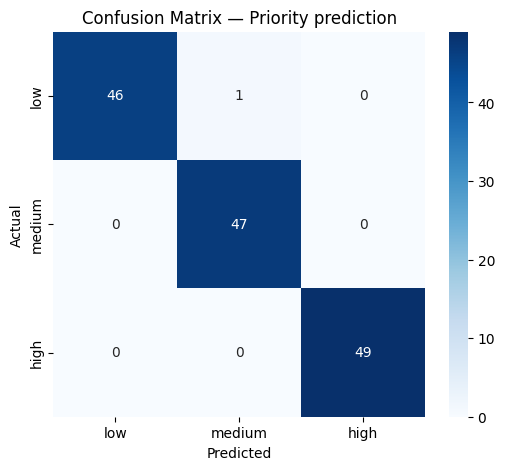

Top 10 feature importances:
worst concave points    0.310664
mean concave points     0.124704
worst concavity         0.089368
mean concavity          0.085830
worst perimeter         0.056390
worst compactness       0.048400
worst area              0.033568
mean compactness        0.031852
worst radius            0.027775
mean perimeter          0.022821
dtype: float64


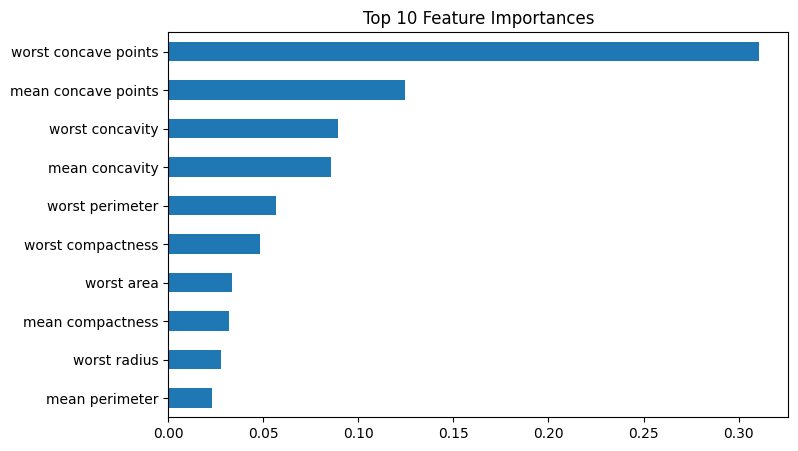

In [ ]:
# %% [markdown]
# # Task 3 — Predictive Analytics for Resource Allocation
# Using the Breast Cancer dataset (as a proxy), create a 3-class "issue priority"
# (high / medium / low) by binning a continuous feature, then train a RandomForest
# and evaluate using Accuracy and F1-score.

# %% [code]
# Standard imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

# For reproducibility
RANDOM_STATE = 42

# %% [code]
# Load dataset (sklearn's breast cancer)
data = load_breast_cancer(as_frame=True)
X = data.data.copy()
y_original = data.target.copy()  # 0,1 (benign/malignant) — we'll ignore as-is and create priority labels

print("Dataset shape:", X.shape)
print("Feature names:", list(X.columns)[:10], "...")
X.head()

# %% [markdown]
# ## Create synthetic 'issue priority' target
# We'll derive a continuous risk score from one of the features and bin it into 3 classes.
# This is only for the assignment — in a real resource allocation problem you'd use real priority labels.

# %% [code]
# Choose a continuous feature that correlates with severity. We'll inspect feature correlations
corr = X.corrwith(pd.Series(y_original)).abs().sort_values(ascending=False)
corr.head(10)

# We'll pick a numerical feature for binning. Let's inspect top candidates:
corr[:8]

# For reproducibility, pick a feature that exists: use the first numeric column as proxy,
# but better: choose 'mean area' if present, otherwise use the highest correlated feature.
feature_choice = corr.index[0]
feature_choice, X[feature_choice].describe()

# Create a continuous 'risk' score from that feature (normalized)
risk = X[feature_choice].values
risk_norm = (risk - risk.min()) / (risk.max() - risk.min())

# Bin into 3 priority levels: low (0), medium (1), high (2)
# We'll choose thresholds at 33% and 66% quantiles
q1 = np.quantile(risk_norm, 0.33)
q2 = np.quantile(risk_norm, 0.66)

def map_priority(val):
    if val <= q1:
        return 0  # low
    elif val <= q2:
        return 1  # medium
    else:
        return 2  # high

y_priority = np.array([map_priority(v) for v in risk_norm])
pd.Series(y_priority).value_counts().sort_index()

# Quick sanity check: add to DataFrame for inspection
X2 = X.copy()
X2['priority'] = y_priority
X2.head()

# %% [markdown]
# ## Train/Test split and preprocessing

# %% [code]
# Features and labels
X_features = X.copy()
y = y_priority

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X_features, y, test_size=0.25, random_state=RANDOM_STATE, stratify=y
)

# Scale features (Random Forest does not require scaling but scaling is helpful for some models/inspection)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Train shape:", X_train.shape, "Test shape:", X_test.shape)

# %% [markdown]
# ## Train Random Forest classifier

# %% [code]
clf = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    random_state=RANDOM_STATE,
    n_jobs=-1,
    class_weight='balanced'  # helps with class imbalance
)
clf.fit(X_train_scaled, y_train)

# %% [code]
# Predictions and evaluation
y_pred = clf.predict(X_test_scaled)

acc = accuracy_score(y_test, y_pred)
f1_macro = f1_score(y_test, y_pred, average='macro')

print(f"Accuracy: {acc:.4f}")
print(f"F1-score (macro): {f1_macro:.4f}")
print("\nClassification report:\n")
print(classification_report(y_test, y_pred, target_names=["low","medium","high"]))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["low","medium","high"], yticklabels=["low","medium","high"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix — Priority prediction")
plt.show()

# %% [code]
# Feature importance (top 10)
feat_imp = pd.Series(clf.feature_importances_, index=X_features.columns).sort_values(ascending=False)
print("Top 10 feature importances:")
print(feat_imp.head(10))
plt.figure(figsize=(8,5))
feat_imp.head(10).plot(kind='barh')
plt.gca().invert_yaxis()
plt.title("Top 10 Feature Importances")
plt.show()

# %% [markdown]
# ## Save model and artifacts (optional)
# If you want to save the trained model:
# from joblib import dump
# dump(clf, "rf_priority_model.joblib")

# %% [markdown]
# ## Notes on methodology and dataset use
# - The Kaggle Breast Cancer dataset (here loaded from sklearn for convenience) is **not** an issue-priority dataset.
# - For the purposes of this assignment we created synthetic labels by binning a continuous clinical measurement into three buckets,
#   then trained a Random Forest to predict those buckets. In a real resource allocation problem you'd use real priority labels (e.g., issue severity).
# - Evaluate both accuracy and F1 (macro) to account for class balance.
